In [1]:
# changing loss function during training
# increasing detail capture range
# (1-a) loss + a other loss
# smoothness penalty
# increased dimensions (2.5d?) for false positives
# k-means clustering: classify different parts of the image
# keep largest connected component

# Implemented with PyTorch Lightning
### Imports
import os
import glob
import argparse

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# MONAI imports
import monai
from monai.transforms import (
    Compose,
    LoadNiftid,
    ScaleIntensityd,
    NormalizeIntensityd,
    AddChanneld,
    ToTensord,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    CropForegroundd,
)

# PyTorch Lightning imports
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.core.lightning import LightningModule

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Norm, Act
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import export
from monai.utils.aliases import alias

In [2]:
### Helper functions
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: "PSEA" + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: "PSEA" + str(animal) in x, masks))
    return [
        {"image": image_file, "mask": mask_file}
        for image_file, mask_file in zip(filtered_images, filtered_masks)
    ]

In [3]:
def create_loader(
    data_dicts, transforms=None, batch_size=1, shuffle=False, num_workers=0
):
    """Creates a MONAI CacheDataset from data dictionaries."""
    dataset = monai.data.CacheDataset(
        data=data_dicts, transform=transforms, cache_rate=1.0
    )
    data_loader = monai.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )
    return data_loader

In [4]:
def get_data_loaders(batch_size, patch_size):
    ### Data collection
    data_dir = "../../data/"
    print("Available directories: ", os.listdir(data_dir))
    # Get paths for images and masks, organize into dictionaries
    images = sorted(glob.glob(data_dir + "**/*CTImg*", recursive=True))
    masks = sorted(glob.glob(data_dir + "**/*Mask*", recursive=True))
    # Dataset selection
    train_dicts = select_animals(images, masks, [12, 13, 14, 18, 20])
    val_dicts = select_animals(images, masks, [25])
    data_keys = ["image", "mask"]
    # Data transformation
    data_transforms = Compose(
        [
            LoadNiftid(keys=data_keys),
            AddChanneld(keys=data_keys),
            NormalizeIntensityd(keys="image"),
            RandCropByPosNegLabeld(
                keys=data_keys, label_key="mask", size=(patch_size, patch_size, 1), num_samples=4, image_key="image"
            ),
            ToTensord(keys=data_keys),
        ]
    )

    # Data loaders
    data_loaders = {
        "train": create_loader(
            train_dicts,
            batch_size=batch_size,
            transforms=data_transforms,
            shuffle=True,
        ),
        "val": create_loader(val_dicts, transforms=data_transforms),
    }
    for key in data_loaders:
        print(key, len(data_loaders[key]))

    return data_loaders

In [5]:
data_loaders = get_data_loaders(64, 256)

Available directories:  ['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'PSEA14 Baseline', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'PSEA25 PostGel', 'PSEA18 PostGel']
Load and cache transformed data...
114/114 [==============================]  
Load and cache transformed data...
30/30 [==============================]  
train 2
val 30


In [6]:
test = monai.utils.misc.first(data_loaders['train'])

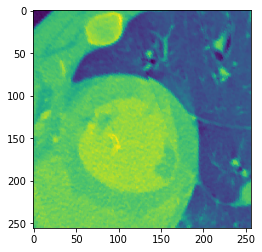

In [10]:
import matplotlib.pyplot as plt


plt.imshow(test['image'][5, 0, :, :, 0])

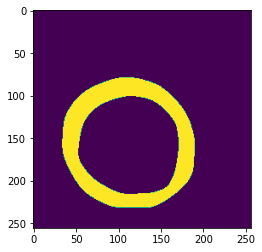

In [11]:
plt.imshow(test['mask'][5, 0, :, :, 0])

In [18]:
class UNet(LightningModule):
    def __init__(
        self,
        dimensions,
        in_channels,
        out_channels,
        channels,
        strides,
        criterion,
        kernel_size=3,
        up_kernel_size=3,
        num_res_units=0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ):
        super().__init__()
        assert len(channels) == (len(strides) + 1)
        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.criterion = criterion
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(inc, outc, channels, strides, is_top):
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.
            """
            c = channels[0]
            s = strides[0]

            if len(channels) > 2:
                subblock = _create_block(
                    c, c, channels[1:], strides[1:], False
                )  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            down = self._get_down_layer(
                inc, c, s, is_top
            )  # create layer in downsampling path
            up = self._get_up_layer(
                upc, outc, s, is_top
            )  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(
            in_channels, out_channels, self.channels, self.strides, True
        )

    def _get_down_layer(self, in_channels, out_channels, strides, is_top):
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides,
                self.kernel_size,
                self.num_res_units,
                self.act,
                self.norm,
                self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides,
                self.kernel_size,
                self.act,
                self.norm,
                self.dropout,
            )

    def _get_bottom_layer(self, in_channels, out_channels):
        return self._get_down_layer(in_channels, out_channels, 1, False)

    def _get_up_layer(self, in_channels, out_channels, strides, is_top):
        conv = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides,
            self.up_kernel_size,
            self.act,
            self.norm,
            self.dropout,
            conv_only=is_top and self.num_res_units == 0,
            is_transposed=True,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                1,
                self.kernel_size,
                1,
                self.act,
                self.norm,
                self.dropout,
                last_conv_only=is_top,
            )
            return nn.Sequential(conv, ru)
        else:
            return conv

    def forward(self, x):
        x = self.model(x)
        return x

    # Lightning training
    def training_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        inputs = inputs.squeeze(4)
        labels = labels.squeeze(4)
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        tensorboard_logs = {"loss/train": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    # Lightning validation
    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        inputs = inputs.squeeze(4)
        labels = labels.squeeze(4)
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"loss/val": avg_loss}
        return {"val_loss": avg_loss, "log": tensorboard_logs}

In [19]:
### Main
def main():

    ### Model training
    criterion = monai.losses.DiceLoss(to_onehot_y=True, do_softmax=True)

    model = UNet(
        dimensions=2,
        in_channels=1,
        out_channels=2,
        channels=(64, 128, 258, 512, 1024),
        strides=(2, 2, 2, 2),
        norm=monai.networks.layers.Norm.BATCH,
        criterion=criterion,
    )
    logger = TensorBoardLogger("tb_logs", name='test')

    trainer = Trainer(
        check_val_every_n_epoch=5,
        default_save_path='test' + "/checkpoints",
        gpus=1,
        max_epochs=100,
        logger=logger,
    )

    trainer.fit(
        model,
        train_dataloader=data_loaders["train"],
        val_dataloaders=data_loaders["val"],
    )

In [20]:
main()

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                                                       | Type            | Params
-------------------------------------------------------------------------------------------
0  | criterion                                                  | DiceLoss        | 0     
1  | model                                                      | Sequential      | 10 M  
2  | model.0                                                    | Convolution     | 769   
3  | model.0.conv                                               | Conv2d          | 640   
4  | model.0.norm                                               | BatchNorm2d     | 128   
5  | model.0.act                                                | PReLU           | 1     
6  | model.1                                                    | SkipConnection  | 10 M  
7  | model.1.submodule                                          

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.92 GiB total capacity; 9.35 GiB already allocated; 591.50 MiB free; 9.78 GiB reserved in total by PyTorch)